In [1]:
import os
import json
import geopandas as gpd
import requests
import osmnx as ox
from dotenv import load_dotenv
from sentinelsat import geojson_to_wkt
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from pydantic import BaseModel

In [7]:
class ExtractBox(BaseModel):
    location: str
    distance: float = 1000.0  # Default distance in meters
    filepath: str

def extract_bbox(**kwargs):
    input = ExtractBox(**kwargs)
    location = input.location
    distance = input.distance
    filepath = input.filepath

    # Generate GeoDataFrame from location
    gdf = ox.geocode_to_gdf(location)
    gdf.to_file(filepath, driver="GeoJSON")
    print(f"✅ GeoJSON file saved as {filepath}")

    # Compute bounding box
    minx, miny, maxx, maxy = gdf.total_bounds

    # ✅ Return structured output
    return {
        "file_path": filepath,
        "bbox": [minx, miny, maxx, maxy]
    }

In [9]:
bbox = extract_bbox(location="Uttarakhand", distance=1000, filepath="uttarakhand_.geojson")["bbox"]


✅ GeoJSON file saved as uttarakhand_.geojson


In [10]:
bbox

[77.57133, 28.7243243, 81.044789, 31.459016]

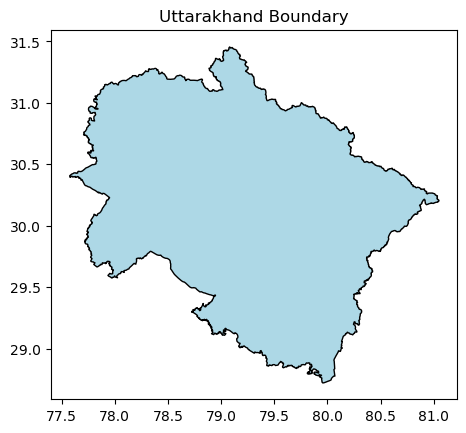

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
gdf = gpd.read_file("uttarakhand_bbox.geojson")

# Plot
gdf.plot(edgecolor='black', facecolor='lightblue')
plt.title("Uttarakhand Boundary")
plt.show()


In [19]:
import folium
import geopandas as gpd

# Load the GeoJSON
gdf = gpd.read_file("uttarakhand.geojson")

# Get center of the shape
center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]

# Create folium map centered at the shape
m = folium.Map(location=center, zoom_start=8)

# Add the GeoJSON overlay to the map
folium.GeoJson(gdf, name="Uttarakhand").add_to(m)

# Optional: add layer control
folium.LayerControl().add_to(m)

# Save the interactive map to HTML
m.save("uttarakhand_map.html")

print("✅ Saved to uttarakhand_map.html")


✅ Saved to uttarakhand_map.html


C:\Users\Debanjan\AppData\Local\Temp\ipykernel_32128\2578353760.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]


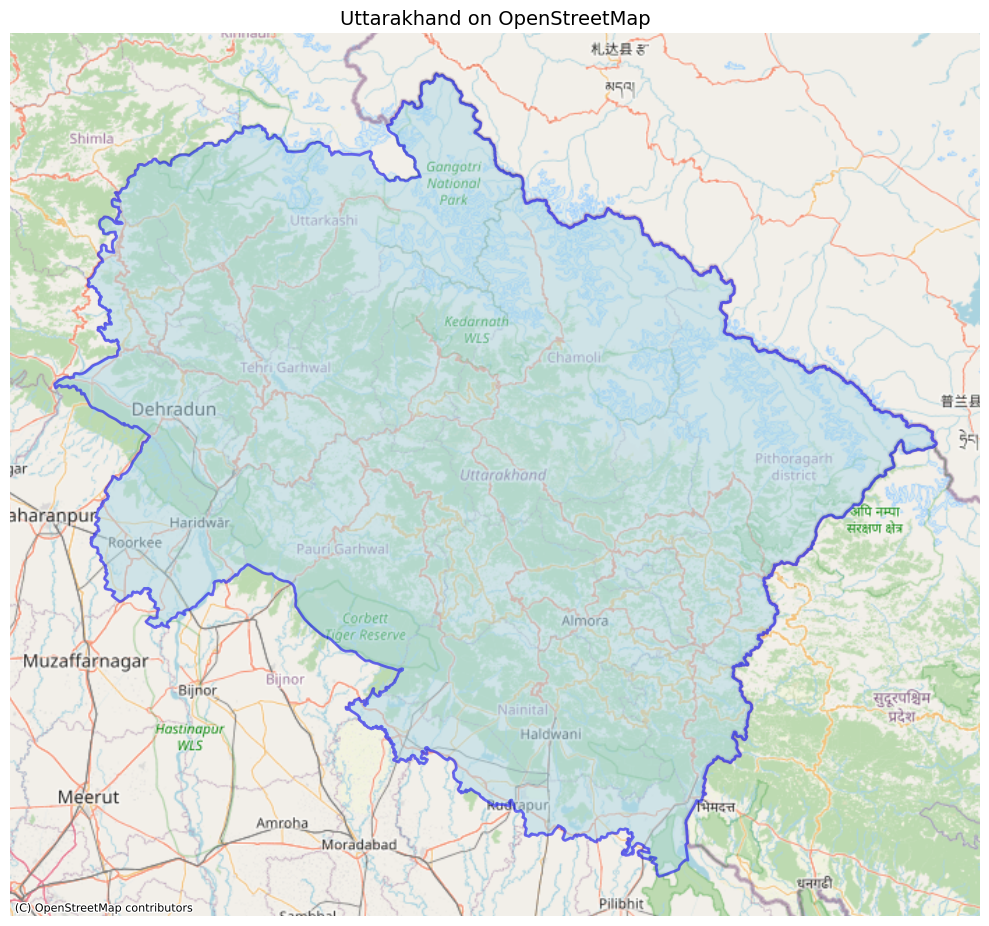

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For OSM basemaps

# Load the GeoJSON boundary
gdf = gpd.read_file("uttarakhand.geojson")

# Project to Web Mercator for tile overlay
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', linewidth=2, alpha=0.5)

# Add OpenStreetMap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Clean up
ax.set_title("Uttarakhand on OpenStreetMap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [16]:
import os
from dotenv import load_dotenv
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")



In [17]:
##########################
# Authentication Utility #
##########################
def get_access_token():
    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)
    token = oauth.fetch_token(
        token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
        client_secret=client_secret,
        include_client_id=True
    )
    return token['access_token']

In [18]:

evalscripts = {
    "ndvi": '''
function setup() {
  return { input: ["B04", "B08"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}''',
"ndwi": '''
function setup() {
  return { input: ["B03", "B08"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
  let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
  return [ndwi];
}'''
}


##########################
# Dataset Type Mapping   #
##########################

SUPPORTED_DATASETS = {
    "ndvi": "sentinel-2-l2a",
    "ndwi": "sentinel-2-l2a",
}


#####################
# Payload Generator #
#####################

class CreatePayload(BaseModel):
    dataset_type: str
    bbox: list
    time_from: str = "2023-01-01T00:00:00Z"
    time_to: str = "2023-12-31T23:59:59Z"
    evalscript: str = None

def create_payload(**kwargs):
    input = CreatePayload(**kwargs)

    dataset_type = input.dataset_type.lower()
    bbox = input.bbox
    time_from = input.time_from
    time_to = input.time_to
    evalscript = input.evalscript

    if dataset_type not in SUPPORTED_DATASETS:
        raise ValueError(f"Unsupported dataset type: {dataset_type}")

    if not evalscript:
        if dataset_type not in evalscripts:
            raise ValueError(f"No default evalscript available for dataset_type '{dataset_type}'")
        evalscript = evalscripts[dataset_type]

    print(f"🛠️ Creating payload for dataset: {dataset_type}, time: {time_from} to {time_to}")

    return {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": SUPPORTED_DATASETS[dataset_type],
                "dataFilter": {
                    "timeRange": {
                        "from": time_from,
                        "to": time_to
                    }
                }
            }]
        },
        "output": {
            "width": 512,
            "height": 512,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": evalscript
    }


##################
# Process Handler #
##################

class ProcessRequest(BaseModel):
    payload: dict
    filepath: str

def process_request(**kwargs) -> str:
    input = ProcessRequest(**kwargs)
    payload = input.payload
    filepath = input.filepath

    if not filepath.endswith(".tif"):
        filepath += ".tif"

    access_token = get_access_token()
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }

    print(f"🚀 Sending request to Sentinel Hub...")
    response = requests.post(
        "https://sh.dataspace.copernicus.eu/api/v1/process",
        headers=headers,
        data=json.dumps(payload)
    )

    if response.ok:
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"✅ Processed data saved to {filepath}")
        return filepath
    else:
        print("❌ Request failed:", response.status_code)
        try:
            print("📄 Error details:", response.json())
        except:
            print("📄 Error content:", response.text)
        raise RuntimeError(f"Sentinel Hub request failed with status {response.status_code}")


In [31]:
payload = create_payload(dataset_type="ndvi", bbox=bbox, time_from="2023-01-01T00:00:00Z", time_to="2023-12-31T23:59:59Z")

🛠️ Creating payload for dataset: ndvi, time: 2023-01-01T00:00:00Z to 2023-12-31T23:59:59Z


In [26]:
payload

{'input': {'bounds': {'bbox': [77.57133, 28.7243243, 81.044789, 31.459016],
   'properties': {'crs': 'http://www.opengis.net/def/crs/EPSG/0/4326'}},
  'data': [{'type': 'sentinel-2-l2a',
    'dataFilter': {'timeRange': {'from': '2023-01-01T00:00:00Z',
      'to': '2023-12-31T23:59:59Z'}}}]},
 'output': {'width': 512,
  'height': 512,
  'responses': [{'identifier': 'default', 'format': {'type': 'image/tiff'}}]},
 'evalscript': '\nfunction setup() {\n  return { input: ["B04", "B08"], output: { bands: 1 } };\n}\nfunction evaluatePixel(sample) {\n  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);\n  return [ndvi];\n}'}

In [29]:
process_request(
    payload=payload,
    filepath="uttarakhand_ndwi.tif"
)

🚀 Sending request to Sentinel Hub...
✅ Processed data saved to uttarakhand_ndwi.tif


'uttarakhand_ndwi.tif'

In [24]:
import rasterio

with rasterio.open("uttarakhand_dem.tif") as src:
    dem = src.read(1)
    print("Min:", dem.min(), "Max:", dem.max())


Min: 255 Max: 255


In [26]:
payload = create_payload(dataset_type="lulc", bbox=bbox, time_from="2023-01-01T00:00:00Z", time_to="2023-12-31T23:59:59Z")

🛠️ Creating payload for dataset: lulc, time: 2023-01-01T00:00:00Z to 2023-12-31T23:59:59Z


In [27]:
process_request(
    payload=payload,
    filepath="uttarakhand_lulc.tif"
)

🚀 Sending request to Sentinel Hub...
❌ Request failed: 400
📄 Error details: {'error': {'status': 400, 'reason': 'Bad Request', 'message': 'Invalid collection type. If using your own data collection, make sure to use the appropriate prefix.', 'code': 'COMMON_BAD_PAYLOAD', 'errors': {'parameter': 'input->data[0]->type', 'invalidValue': 'WorldCover'}}}


RuntimeError: Sentinel Hub request failed with status 400

In [46]:
bbox

[np.float64(77.57133),
 np.float64(28.7243243),
 np.float64(81.044789),
 np.float64(31.459016)]

In [47]:
import geopandas as gpd

def get_area(bbox):
   
    minx, miny, maxx, maxy = bbox
    area = [maxy, minx, miny, maxx]  # Convert to [N, W, S, E]
    return area
    

[np.float64(31.459016),
 np.float64(77.57133),
 np.float64(28.7243243),
 np.float64(81.044789)]

In [11]:
import xarray as xr
import rasterio
from rasterio.transform import from_origin
import numpy as np

def convert_nc_tif(netcdf_path: str, output_tif_path: str):

    # 1. Load the NetCDF file
    ds = xr.open_dataset(netcdf_path)

    # 2. Extract total precipitation (assuming single time step)
    precip = ds['tp'][0]
    lat = precip.latitude.values
    lon = precip.longitude.values
    data = precip.values

    # 3. Flip data if latitude is decreasing
    if lat[0] > lat[-1]:
        lat = lat[::-1]
        data = data[::-1, :]

    # 4. Define geotransform
    res_lon = abs(lon[1] - lon[0])
    res_lat = abs(lat[1] - lat[0])
    transform = from_origin(
        west=lon[0],
        north=lat[-1] + len(lat) * res_lat,
        xsize=res_lon,
        ysize=res_lat
    )

    # 5. Save to GeoTIFF
    with rasterio.open(
        output_tif_path,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype='float32',
        crs='EPSG:4326',
        transform=transform
    ) as dst:
        dst.write(data.astype('float32'), 1)

    print(f"✅ Saved: {output_tif_path}")


In [12]:
import cdsapi
def get_precipitation(bbox , input_path ):
    c = cdsapi.Client()
    base_name = os.path.splitext(os.path.basename(input_path))[0]
    area = get_area(bbox)
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': 'total_precipitation',
            'year': '2023',
            'month': '08',
            'time': '00:00',
            'area': area,  # [North, West, South, East]
            'format': 'netcdf',
        },
        base_name + '.nc'
    )
    convert_nc_tif(base_name + '.nc', base_name + '.tif')
    


In [13]:
get_precipitation(bbox, "uttarakhand_precipitation.tif")

2025-06-25 14:31:11,754 WARNING [2025-06-23T00:00:00] Scheduled System Session affecting Service reliability - 30 June 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-30-june-2025/13598)
2025-06-25 14:31:11,755 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-25 14:31:11,756 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-25 14:31:11,756 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


NameError: name 'get_area' is not defined

In [109]:
import osmnx as ox
import geopandas as gpd

def extract_rivers(place_name: str ):
    # --- Fetch OSM features ---
    base_name = os.path.basename(place_name).split("_bbox")[0]

    output_path = f"{base_name}_rivers.geojson"
    print(f"🔍 Downloading OSM rivers for: {place_name}")
    gdf = ox.features_from_place(place_name, {"waterway": True})

    # --- Filter only rivers and streams ---
    rivers = gdf[gdf['waterway'].isin(['river', 'stream'])]

    # --- Save to GeoJSON ---
    rivers.to_file(output_path, driver="GeoJSON")
    print(f"✅ Saved: {output_path}")
    return {output_path : output_path}



In [110]:
class GenerateDistanceAndDrainageDensity(BaseModel):
    region_path: str
    resolution: int = 100  # in meters
    density_window: int = 1000  # in meters


def generate_distance_and_drainage_density(**kwargs):
    input  = GenerateDistanceAndDrainageDensity(**kwargs)
    region_path = input.region_path
    resolution = input.resolution
    density_window = input.density_window
    # === Load region and rivers ===
    region = gpd.read_file(region_path).to_crs("EPSG:4326")
    base_name = os.path.splitext(os.path.basename(region_path))[0]
    rivers_path = extract_rivers(region_path)
    
    rivers = gpd.read_file(rivers_path).to_crs(region.crs)

    # === Define raster grid ===
    minx, miny, maxx, maxy = region.total_bounds
    width = int((maxx - minx) / (resolution / 111320))  # ~100m in degrees
    height = int((maxy - miny) / (resolution / 111320))
    transform = from_origin(minx, maxy, (maxx - minx) / width, (maxy - miny) / height)

    # === Rasterize river lines ===
    river_raster = rasterize(
        [(geom, 1) for geom in rivers.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    # === Get pixel centers
    xs = np.linspace(minx + 0.5 * transform.a, maxx - 0.5 * transform.a, width)
    ys = np.linspace(maxy - 0.5 * abs(transform.e), miny + 0.5 * abs(transform.e), height)
    grid_points = np.array([(x, y) for y in ys for x in xs])

    # === Get all river coordinates
    river_coords = []
    for geom in rivers.geometry:
        if geom.geom_type == "LineString":
            river_coords.extend(list(geom.coords))
        elif geom.geom_type == "MultiLineString":
            for line in geom.geoms:
                river_coords.extend(list(line.coords))
    river_coords = np.array(river_coords)

    # === Build KDTree and compute distances
    tree = cKDTree(river_coords)
    dists, _ = tree.query(grid_points, k=1)
    dist_raster = dists.reshape((height, width)).astype('float32') * 111320  # Convert deg to meters

    # === Compute drainage density (using moving window sum of river pixels)
    kernel_size = int(density_window / resolution)
    padded = np.pad(river_raster, kernel_size // 2, mode='constant')
    density_raster = np.zeros_like(river_raster, dtype='float32')

    for i in tqdm(range(height)):
        for j in range(width):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            pixel_area_km2 = (resolution / 1000) ** 2
            river_length_km = window.sum() * (resolution / 1000)
            density_raster[i, j] = river_length_km / (kernel_size**2 * pixel_area_km2)

    # === Save distance raster
    profile = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': 'float32',
        'crs': 'EPSG:4326',
        'transform': transform
    }

    with rasterio.open(base_name+"_river_proximity.tif", 'w', **profile) as dst:
        dst.write(dist_raster, 1)

    with rasterio.open(base_name+ "_drainage_density.tif", 'w', **profile) as dst:
        dst.write(density_raster, 1)

    return {
        "distance_raster": base_name + "_river_proximity.tif",
        "density_raster": base_name + "_drainage_density.tif",
    }
    
# Example usage
result = generate_distance_and_drainage_density(
    region_path="uttarakhand_bbox.geojson",
    resolution=100,
    density_window=1000
)

TypeError: features_from_bbox() got multiple values for argument 'tags'

In [68]:
from rasterio.transform import from_origin
import numpy as np
import geopandas as gpd

def create_reference_grid_from_geojson(geojson_path, resolution=0.001):
    gdf = gpd.read_file(geojson_path).to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.total_bounds

    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)

    transform = from_origin(minx, maxy, resolution, resolution)

    meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": "EPSG:4326",
        "transform": transform,
    }

    return meta



In [36]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_origin

# --- Normalize raster ---
def normalize(array):
    array = np.where(np.isnan(array), 0, array)
    arr_min = np.min(array)
    arr_max = np.max(array)
    if arr_max == arr_min:
        return np.zeros_like(array)
    return (array - arr_min) / (arr_max - arr_min)

# --- Build reference grid from AOI ---
def create_reference_grid_from_geojson(geojson_path, resolution=0.001):
    gdf = gpd.read_file(geojson_path).to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.total_bounds

    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = from_origin(minx, maxy, resolution, resolution)

    meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": "EPSG:4326",
        "transform": transform,
    }

    return gdf, meta

# --- Clip and read raster ---
def load_and_clip(path, region):
    with rasterio.open(path) as src:
        out_image, _ = mask(src, region.geometry, crop=True)
        return out_image[0], src.meta.copy()

# --- Resample raster to match reference ---
def resample_to_match(source_array, source_meta, target_meta):
    dst_array = np.zeros((target_meta["height"], target_meta["width"]), dtype=np.float32)
    reproject(
        source=source_array,
        destination=dst_array,
        src_transform=source_meta["transform"],
        src_crs=source_meta["crs"],
        dst_transform=target_meta["transform"],
        dst_crs=target_meta["crs"],
        resampling=Resampling.bilinear
    )
    return dst_array

# --- Flood risk computation ---
def compute_flood_risk(dem_path , precip_path, dist_path, density_path, region_path , output_path):
    region, ref_meta = create_reference_grid_from_geojson(region_path, resolution=0.001)

    # Load & clip input rasters
    dem_raw, dem_meta = load_and_clip(dem_path, region)
    precip_raw, precip_meta = load_and_clip(precip_path, region)
    dist_raw, dist_meta = load_and_clip(dist_path, region)
    density_raw, density_meta = load_and_clip(density_path, region)

    # Resample to reference grid
    dem = resample_to_match(dem_raw, dem_meta, ref_meta)
    precip = resample_to_match(precip_raw, precip_meta, ref_meta)
    dist = resample_to_match(dist_raw, dist_meta, ref_meta)
    density = resample_to_match(density_raw, density_meta, ref_meta)

    print("DEM shape:", dem.shape)
    print("Precip shape:", precip.shape)
    print("Dist shape:", dist.shape)
    print("Density shape:", density.shape)

    # Normalize
    dem_norm = normalize(dem)
    precip_norm = normalize(precip)
    dist_norm = normalize(dist)
    density_norm = normalize(density)

    # Combine with weights
    flood_risk = (
        0.25 * precip_norm +
        0.25 * (1 - dem_norm) +
        0.25 * (1 - dist_norm) +
        0.25 * density_norm
    )

    # Save output
    with rasterio.open(output_path, 'w', **ref_meta) as dst:
        dst.write(flood_risk.astype('float32'), 1)

    print(f"✅ Saved: {output_path}")

compute_flood_risk("uttarakhand_dem.tif", 
                   "uttarakhand_precipitation.tif",
                   "uttarakhand_river_proximity.tif",
                   "uttarakhand_drainage_density.tif",
                   "uttarakhand_bbox.geojson",
                   "uttarakhand_flood_risk.tif")


DEM shape: (2734, 3473)
Precip shape: (2734, 3473)
Dist shape: (2734, 3473)
Density shape: (2734, 3473)
✅ Saved: uttarakhand_flood_risk.tif


C:\Users\Debanjan\AppData\Local\Temp\ipykernel_42972\3017837108.py:18: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\CodeBook\ISRO\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


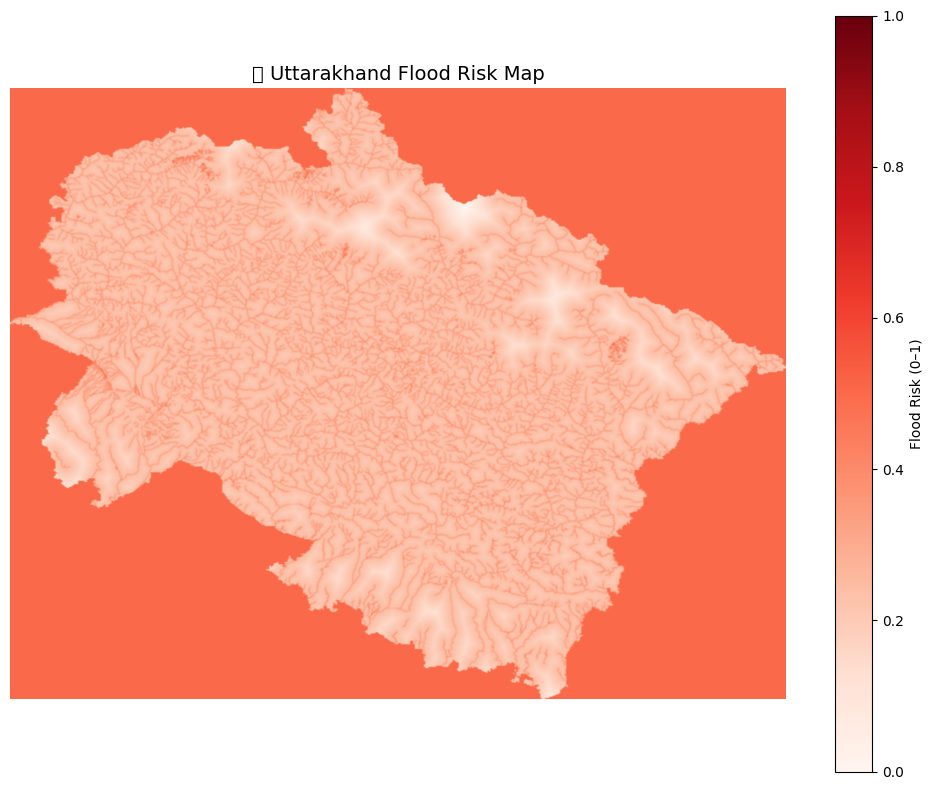

In [37]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Load flood risk raster
with rasterio.open("uttarakhand_flood_risk.tif") as src:
    flood_risk = src.read(1)
    crs = src.crs
    transform = src.transform

# Plot
plt.figure(figsize=(10, 8))
norm = Normalize(vmin=0, vmax=1)
plt.imshow(flood_risk, cmap="Reds", norm=norm)
plt.title("🛑 Uttarakhand Flood Risk Map", fontsize=14)
plt.colorbar(label="Flood Risk (0–1)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [49]:
# Load your flood risk map
import numpy as np
import rasterio

with rasterio.open("uttarakhand_flood_risk.tif") as src:
    flood_risk = src.read(1)

# Classify into 3 discrete classes: 1 = Low, 2 = Moderate, 3 = High
risk_classified = np.zeros_like(flood_risk, dtype=np.uint8)
risk_classified[(flood_risk >= 0.0) & (flood_risk < 0.2)] = 1  # Low risk
risk_classified[(flood_risk >= 0.2) & (flood_risk <= 0.5)] = 2  # Moderate risk
risk_classified[(flood_risk >= 0.6)] = 3                       # High risk


C:\Users\Debanjan\AppData\Local\Temp\ipykernel_42972\3370884171.py:16: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\CodeBook\ISRO\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


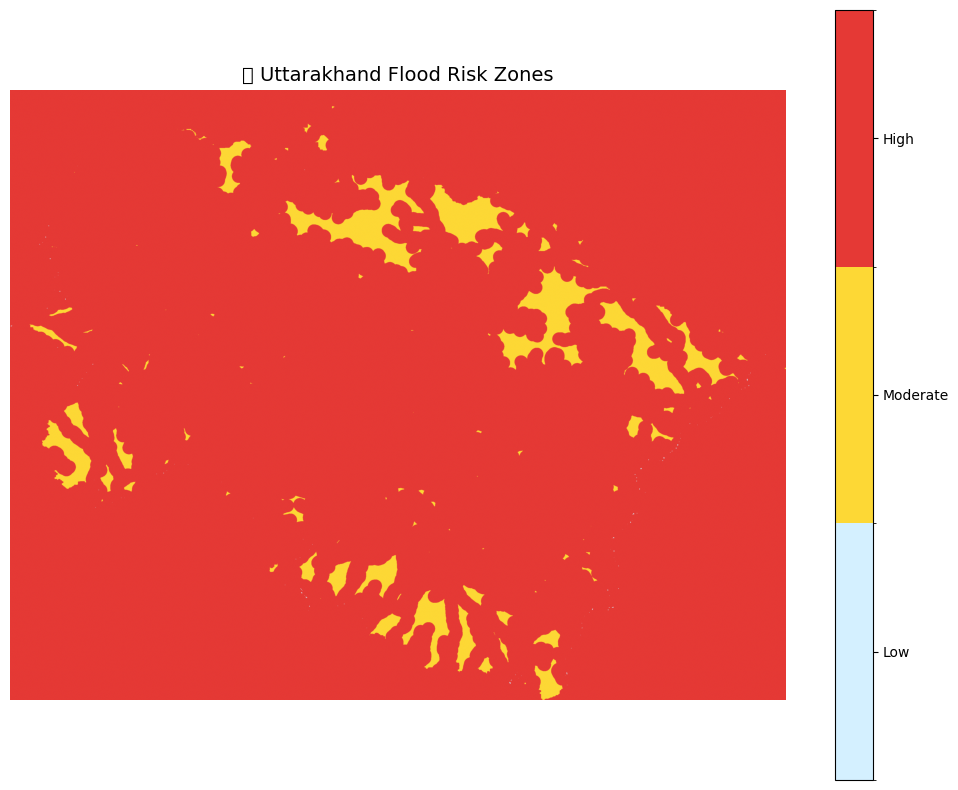

In [50]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create distinct colormap
cmap = ListedColormap(['#d4f0ff', '#fdd835', '#e53935'])  # Light Blue, Yellow, Red
bounds = [0, 1, 2, 3]
norm = BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(risk_classified, cmap=cmap, norm=norm)
plt.title("🛑 Uttarakhand Flood Risk Zones", fontsize=14)
cbar = plt.colorbar(ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['Low', 'Moderate', 'High'])
plt.axis('off')
plt.tight_layout()
plt.show()


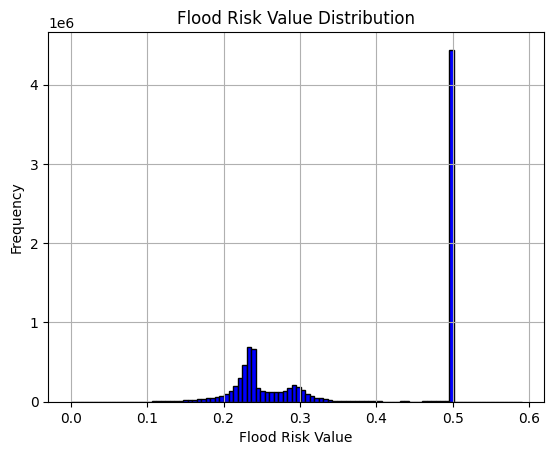

In [46]:
import matplotlib.pyplot as plt

plt.hist(flood_risk.flatten(), bins=100, color='blue', edgecolor='black')
plt.title("Flood Risk Value Distribution")
plt.xlabel("Flood Risk Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [86]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from rasterio.warp import transform_bounds
from matplotlib.colors import Normalize

def generate_flood_risk_overlay(
    vector_path: str = "uttarakhand.geojson",
    raster_path: str = "uttarakhand_flood_risk.tif",
    output_path: str = "flood_risk_overlay_clean.png"
):

    # === Load vector boundary ===
    region = gpd.read_file(vector_path).to_crs("EPSG:4326")

    # === Load flood risk raster ===
    with rasterio.open(raster_path) as src:
        flood_risk = src.read(1)
        transform = src.transform
        bounds = transform_bounds(src.crs, "EPSG:4326", *src.bounds)
        shape = src.shape

    # === Mask flood risk outside vector boundary ===
    mask_arr = geometry_mask(region.geometry, transform=transform, invert=True, out_shape=shape)
    masked_risk = np.where(mask_arr, flood_risk, np.nan)

    # === Save clean transparent overlay ===
    plt.figure(figsize=(10, 10))
    norm = Normalize(vmin=0, vmax=1)
    plt.imshow(masked_risk, cmap="Reds", norm=norm)
    plt.axis("off")
    cbar = plt.colorbar(fraction=0.03, pad=0.01)
    cbar.set_label("Flood Risk (0–1)", size=12)
    plt.tight_layout()

    plt.savefig(output_path,
                dpi=300,
                bbox_inches='tight',
                pad_inches=0,
                transparent=True,
                facecolor='none')
    plt.close()

    print(f"✅ Saved: {output_path}")


In [51]:
import folium
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from rasterio.mask import mask
import tempfile
import os

def overlay_masked_raster_on_osm(
    raster_path: str,
    vector_path: str ,
    output_html: str ,
    zoom_start: int = 8,
    opacity: float = 0.6
):
    # === Load region ===
    region = gpd.read_file(vector_path).to_crs("EPSG:4326")

    # === Load and mask raster ===
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, region.geometry, crop=True)
        data = out_image[0]
        bounds = rasterio.transform.array_bounds(*data.shape, out_transform)
        bounds = [out_transform * (0, 0), out_transform * (data.shape[1], data.shape[0])]
        bounds = [[bounds[0][1], bounds[0][0]], [bounds[1][1], bounds[1][0]]]  # [[south, west], [north, east]]

    # === Normalize for colormap ===
    data = np.where(np.isnan(data), 0, data)
    norm = Normalize(vmin=0, vmax=1)
    img_norm = norm(data)

    # === Save as temporary PNG ===
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
        ax.imshow(img_norm, cmap='Reds', interpolation='nearest')
        ax.axis("off")
        fig.savefig(tmp.name, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()
        img_path = tmp.name

    # === Center map ===
    center_lat = (bounds[0][0] + bounds[1][0]) / 2
    center_lon = (bounds[0][1] + bounds[1][1]) / 2

    # === Create folium map ===
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start)

    folium.raster_layers.ImageOverlay(
        name="Flood Risk",
        image=img_path,
        bounds=bounds,
        opacity=opacity,
        interactive=True,
        cross_origin=False,
        zindex=1
    ).add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_html)
    print(f"✅ Saved: {output_html}")

    # Cleanup temp image
    os.remove(img_path)

overlay_masked_raster_on_osm("uttarakhand_flood_risk.tif" , "uttarakhand_bbox.geojson", "uttarakhand_flood_risk_map.html", zoom_start=8, opacity=0.6)


✅ Saved: uttarakhand_flood_risk_map.html


In [2]:
import rasterio
with rasterio.open("uttarakhand_dem.nc") as src:
    print(src.read(1))  # Print DEM elevation matrix


[[0.00870265 0.00859203 0.00823821 0.00597038 0.00429096 0.00281085
  0.00157012 0.00122585 0.00119819 0.00122108 0.0014738  0.00201358
  0.00219764 0.0025381 ]
 [0.00680961 0.00655021 0.00858249 0.00975932 0.00815238 0.00581493
  0.00395812 0.00301398 0.00216808 0.00141372 0.00089111 0.00084914
  0.00100078 0.00142707]
 [0.00906314 0.00824107 0.00930919 0.01292362 0.0141796  0.01142349
  0.01040878 0.00940551 0.00630416 0.00383224 0.00226535 0.00205173
  0.00192966 0.00205363]
 [0.00883235 0.01183357 0.01201095 0.01281394 0.01392402 0.0159296
  0.02163257 0.02385082 0.01780166 0.01006736 0.00542583 0.00447406
  0.00392188 0.0030178 ]
 [0.00518073 0.00820674 0.0105442  0.01211967 0.01262893 0.01194228
  0.01283874 0.0141138  0.01313438 0.01085128 0.01098384 0.01026191
  0.00736179 0.00542011]
 [0.00527229 0.0069498  0.0080799  0.01039352 0.01320018 0.01384868
  0.01206149 0.01027526 0.01161041 0.01576747 0.02040805 0.021212
  0.01656474 0.01289691]
 [0.00442065 0.00653877 0.00729026 0.

In [77]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import os

def save_folium_map_as_png(html_path: str, png_output: str, delay: int = 3, width: int = 1024, height: int = 768):
    """
    Renders a Folium HTML map and saves it as a PNG image using headless Chrome.

    Args:
        html_path (str): Path to the HTML file.
        png_output (str): Path where the PNG will be saved.
        delay (int): Seconds to wait before taking the screenshot (ensure tiles load).
        width (int): Width of the browser window.
        height (int): Height of the browser window.
    """

    options = Options()
    options.add_argument("--headless")
    options.add_argument(f"--window-size={width},{height}")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")

    # Path setup
    html_file = "file://" + os.path.abspath(html_path)

    driver = webdriver.Chrome(options=options)
    try:
        driver.get(html_file)
        time.sleep(delay)  # wait for tiles to load
        driver.save_screenshot(png_output)
        print(f"✅ Saved PNG: {png_output}")
    finally:
        driver.quit()


In [92]:
save_folium_map_as_png(
    html_path="masked_flood_risk_map.html",
    png_output="masked_flood_risk_map.png",
    delay=5,
    width=1024,
    height=768
)

✅ Saved PNG: masked_flood_risk_map.png


In [111]:
place_name = "uttarakhand_bbox.geojson"
base_name = os.path.basename(place_name).split("_bbox")[0]

In [112]:
base_name

'uttarakhand'